## Reimplementing Faster R-CNN using TensorFlow.

### Steps
 1. Create the convolutional layers, by taking a model pretrained on ImageNet and use Transfer Learning.


### Resources

 For transfer learning from MobileNet V2:
 1. https://www.tensorflow.org/tutorials/images/transfer_learning
 2. https://www.tensorflow.org/tutorials/images/transfer_learning
 3. https://arxiv.org/pdf/1506.01497.pdf
 4. https://www.youtube.com/watch?v=nDPWywWRIRo
 
### TODO 
While doing the classification, fix the imbalanced dataset by adding weights to labels.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#tf.compat.v1.enable_eager_execution()

In [2]:
dataset = tfds.load(name="voc", split=tfds.Split.TRAIN)

classes = [ 'Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable', 
           'Dog', 'Horse', 'Motorbike', 'Person','Pottedplant', 'Sheep', 'Sofa', 'Train', 'Tvmonitor']

# In the paper for images they kept the ratio, in mine the images were made square
IMG_SIZE = 600   
def preprocess(row):
    row['image'] = tf.image.resize(row['image'], (IMG_SIZE, IMG_SIZE))
    row['image'] = row['image'] / 255
    
    return {'image':row['image'], 'labels':row['labels'], 'objects':row['objects'], 'filename':row['image/filename']}

dataset = dataset.map(lambda row: preprocess(row))

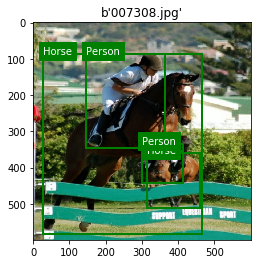

In [6]:
from matplotlib.font_manager import FontProperties

def bbox_perc_to_pixels(bbox):
    y_start, y_finish = bbox[0] * IMG_SIZE, bbox[2] * IMG_SIZE
    x_start, x_finish = bbox[1] * IMG_SIZE, bbox[3] * IMG_SIZE
    return y_start, x_start, y_finish, x_finish

for row in dataset.take(1):    
    _, ax = plt.subplots(1)
    ax.imshow(row['image'].numpy().astype(float))
    
    for bbox, label in zip(row['objects']['bbox'].numpy(), row['objects']['label'].numpy()):
        y_start, x_start, y_finish, x_finish = bbox_perc_to_pixels(bbox)
        
        rect = patches.Rectangle((x_start, y_start), x_finish-x_start, y_finish-y_start, linewidth=2,
                                 edgecolor='green', facecolor='none')
        ax.add_patch(rect)       
        plt.text(x_start, y_start, classes[label], color='white', backgroundcolor='green')
    
    plt.title(row['filename'].numpy())
    plt.show()

In [9]:
TRAIN_SIZE=1 # 2000  # TODO: start with 100 images

dataset.shuffle(buffer_size=2501)
train = dataset.take(TRAIN_SIZE)
validation = dataset.skip(TRAIN_SIZE).take(250)
testing = dataset.skip(TRAIN_SIZE + 250).take(250)

At each sliding-window location, we simultanously predict multiple regions proposals:
1. "reg" layer has 4k outputs encoding the coordinates of k boxes (k=9: 3 shape ratios & 3 shape sizes)
    * the 4 outputs are: x, y, w & h: the box center coordinates and its width and height (see loss function)
2. "cls" layer outputs 2k scores that estimate probability of object or not for each proposal. (this is
    implemented  as a 2-class softmax layer)

In [47]:
import time

# In preprocess_data.ipynb (in the same folder as this notebook) 
# is the functions that process the values used for regression (distance from anchor to ground truth object) 
# and classification (intersection over union) labels used by the Region Proposing Network
%run preprocess_data.ipynb

def run_processing():
    start = time.time()
    regression_values_dataset = np.zeros((TRAIN_SIZE,17,17,3,3,4))
    classification_values_dataset = np.zeros((TRAIN_SIZE,17,17,9))

    for i, row in enumerate(train):
        regression_values_dataset[i], classification_values_dataset[i] = prepare_output_values(row)
    #regression_values_dataset = regression_values_dataset.reshape((TRAIN_SIZE,17,17,36))
    
    np.save('regression_values_dataset.npy', regression_values_dataset)
    np.save('classification_values_dataset.npy', classification_values_dataset)
    
    print('Time taken: ' + str(int(time.time() - start)) + 's')

# Only rerun the processing if the dataset changed.
run_processing()

Time taken: 0s


In [50]:
regression_values_dataset = np.load('regression_values_dataset.npy')
classification_values_dataset = np.load('classification_values_dataset.npy')

print(regression_values_dataset.shape)
print(classification_values_dataset.shape)

(1, 17, 17, 3, 3, 4)
(1, 17, 17, 9)


In [52]:
def draw_all_groundtruth_objects(row, ax):
    for bbox, label in zip(row['objects']['bbox'].numpy(), row['objects']['label'].numpy()):
        y_start, x_start, y_finish, x_finish = bbox_perc_to_pixels(bbox)
        
        rect = patches.Rectangle((x_start, y_start), x_finish-x_start, y_finish-y_start, linewidth=2,
                                 edgecolor='green', facecolor='none')
        ax.add_patch(rect)

anchor_y1=300.0,anchor_x1=333.33333333333337,anchor_y2=556.0,anchor_x2=461.33333333333337
anchor_y1=33.333333333333336,anchor_x1=100.0,anchor_y2=289.3333333333333,anchor_x2=228.0
anchor_y1=233.33333333333334,anchor_x1=533.3333333333334,anchor_y2=1257.3333333333333,anchor_x2=1045.3333333333335


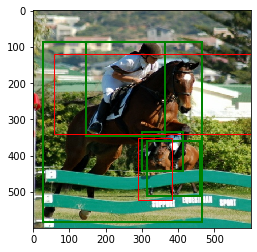

In [54]:
# Visualize the computed regression values
# Green is the round truth object
# Red is the anchor + regression offset object

scale = IMG_SIZE / 17
for im, row in enumerate(train.take(1)):   
    image = row['image'].numpy().astype(float)
    plt.imshow(image)
    ax = plt.gca()
    
    draw_all_groundtruth_objects(row, ax)
    
    all_possible_anchors = list(get_all_anchors())
    
    # get the ground truth from 3 random spots
    for _ in range(3):
        #TODO shpuld select randomly from anchors_map
        
        #k = int(np.random.rand() * len(all_possible_anchors))
        #anchor_y1, anchor_x1, anchor_y2, anchor_x2, i, j, r, s = all_possible_anchors[k]
        
        print("anchor_y1={0},anchor_x1={1},anchor_y2={2},anchor_x2={3}".format(
            anchor_y1, anchor_x1, anchor_y2, anchor_x2))
        
        distance = regression_values_dataset[im][i][j].reshape((3,3,4))
        
        groundtruth_x1, groundtruth_y1, groundtruth_width, groundtruth_height = \
            anchor_and_distance_to_groundtruth(anchor_y1, anchor_x1, anchor_y2, anchor_x2, distance)
                        
        rect = patches.Rectangle((groundtruth_x1, groundtruth_y1), 
                                groundtruth_width, groundtruth_height, 
                                linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
                        
    plt.show()

In [40]:
#labels = classification_values_dataset
#r = np.random.rand(*labels.shape)

In [8]:
# TODO classification_values_dataset that have nan need to be removed.

In [9]:
images_dataset = np.zeros((TRAIN_SIZE, IMG_SIZE, IMG_SIZE, 3))
for i, row in enumerate(train):
    images_dataset[i] = row['image'].numpy().astype(float)

In [10]:
#BATCH_SIZE = 1
#def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
#    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#    ds = ds.cache()
#    ds = ds.repeat()  # Repeat forever    
#    #ds = ds.map(normalize, num_parallel_calls=AUTOTUNE)    
#    ds = ds.batch(BATCH_SIZE)     
#    # dataset fetches batches in the background while the model is training.
#    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#    return ds
#train_it = prepare_for_training(train)

In [11]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False

To increase performance we will train the top layers of the RegionProposalNetwork separately 
from the convolutional layers. We can do this because the conv. layers are frozen (their weights are not changed)

In [12]:
# 1. First we get the output of the convolutional layers for each of the train images:
convolutions_output = base_model.predict(images_dataset)

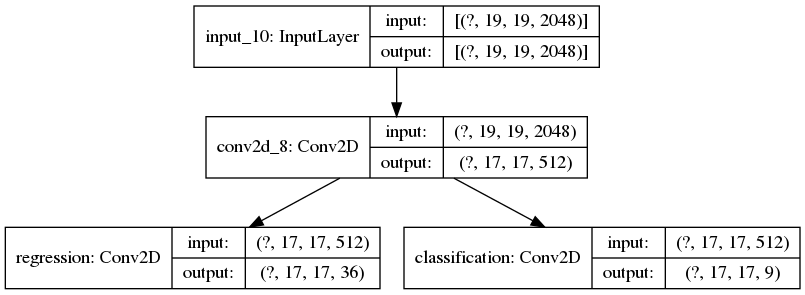

In [53]:
from tensorflow.compat.v1.keras.initializers import RandomNormal

#https://www.tensorflow.org/guide/keras/functional
inputs = tf.keras.Input(shape=(19, 19, 2048))

c = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', 
        bias_initializer='zeros', kernel_initializer=RandomNormal(mean=0.0, stddev=0.1))(inputs)

regression = tf.keras.layers.Conv2D(36, (1, 1), bias_initializer='zeros', 
                            kernel_initializer=RandomNormal(mean=0.0, stddev=0.01), name='regression')(c)

# I cannot have softmax here because I'm predicting  multiple types of shapes and they all can have 100%
classification = tf.keras.layers.Conv2D(9, (1, 1), bias_initializer='zeros', 
                            kernel_initializer=RandomNormal(mean=0.0, stddev=0.001), name='classification')(c)

model = tf.keras.Model(inputs=inputs, outputs=[regression, classification])

tf.keras.utils.plot_model(model, show_shapes=True)

In [54]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss={'regression': 'mae', # 'mse', # TODO Is mae the right one?
                    'classification': 'mae', # 'mse',  #tf.losses.BinaryCrossentropy()
                   },              
              metrics= {#'classification': [tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
              }
             )
#model.summary()

In [55]:
labels.shape
#17 **2

(100, 17, 17, 9)

In [51]:
history = model.fit(x=convolutions_output,
                    y={'regression': regression_values_dataset,
                    'classification': labels},
                    batch_size=1,
                    epochs=10
                    #validation_data=validation_batches
                   )

Train on 100 samples
Epoch 1/10
100/100 [==============================] - 22s 219ms/sample - loss: 0.9517 - regression_loss: 0.7799 - classification_loss: 0.1717
Epoch 2/10
100/100 [==============================] - 23s 235ms/sample - loss: 0.8836 - regression_loss: 0.7480 - classification_loss: 0.1356
Epoch 3/10
100/100 [==============================] - 22s 225ms/sample - loss: 0.8896 - regression_loss: 0.7768 - classification_loss: 0.1129
Epoch 4/10
100/100 [==============================] - 23s 225ms/sample - loss: 0.8702 - regression_loss: 0.7490 - classification_loss: 0.1212
Epoch 5/10
100/100 [==============================] - 22s 221ms/sample - loss: 0.8652 - regression_loss: 0.7565 - classification_loss: 0.1087
Epoch 6/10
100/100 [==============================] - 22s 217ms/sample - loss: 0.8364 - regression_loss: 0.7231 - classification_loss: 0.1133
Epoch 7/10
100/100 [==============================] - 23s 229ms/sample - loss: 0.7824 - regression_loss: 0.6684 - classificatio

In [ ]:
Epoch 10/10 - 25s 248ms/sample - loss: 0.7085 - regression_loss: 0.6910 - classification_loss: 0.0175

# New technique: changed loss to mse   
#Epoch 3/3 - loss: 0.0794 - regression_loss: 0.0660 - classification_loss: 0.0134

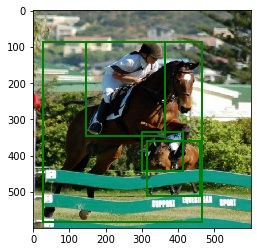

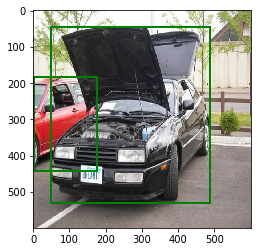

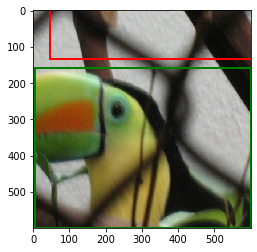

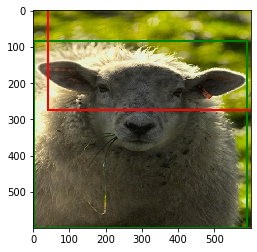

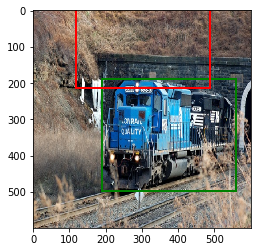

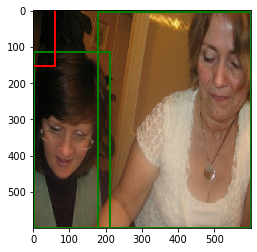

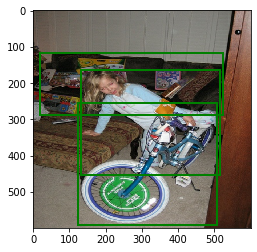

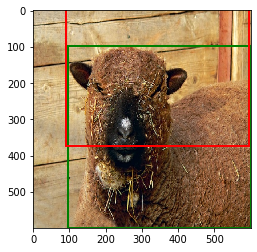

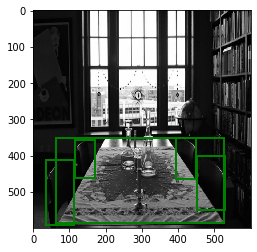

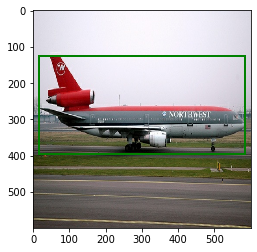

In [56]:
NR_IMAGES = 10
predictions_regr, predictions_class  = model.predict(convolutions_output[:NR_IMAGES])

scale = IMG_SIZE / 17
for i, row in enumerate(train.take(NR_IMAGES)):   
    image = row['image'].numpy().astype(float)
    plt.imshow(image)

    ax = plt.gca()

    for bbox, label in zip(row['objects']['bbox'].numpy(), row['objects']['label'].numpy()):
        y_start, x_start, y_finish, x_finish = bbox_perc_to_pixels(bbox)
        
        rect = patches.Rectangle((x_start, y_start), x_finish-x_start, y_finish-y_start, linewidth=2,
                                 edgecolor='green', facecolor='none')
        ax.add_patch(rect)
        
    # select top 3 proposals per image:    
    top3_value = np.sort(predictions_class[i].reshape(-1))[-1]
        
    for row, _ in enumerate(predictions_class[i]):
        for column, _ in enumerate(predictions_class[i][row]):
            # the 9 types of shapes & ratios
            for r, ratio in enumerate(((1, 1), (1, 2), (2, 1))):
                for s, size in enumerate((128, 256, 512)):
                    
                    if predictions_class[i][row][column][r*3+s] >= top3_value:
                        
                        t_x, t_y, t_w, t_h = regression_values_dataset[i][row][column].reshape((4,9))[:, r*3+s]
                        #t_x, t_y, t_w, t_h = predictions_regr[i][row][column].reshape((4,9))[:, r*3+s]
                                            
                        anchor_box_width = ratio[1] * size
                        anchor_box_height = ratio[0] * size
                        
                        # We apply the offsets between anchor_box and ground-truth box from regression
                        groundtruth_x1 = column * scale + t_x * anchor_box_width
                        groundtruth_y1 = row * scale + t_y * anchor_box_height
                        groundtruth_width = anchor_box_width * np.e ** t_w
                        groundtruth_height = anchor_box_height * np.e ** t_h
                        
                            
                        rect = patches.Rectangle((groundtruth_x1, groundtruth_y1), 
                                                     groundtruth_width, 
                                                     groundtruth_height, 
                                                     linewidth=2,
                                edgecolor='red', facecolor='none')
                        ax.add_patch(rect)
                        
    plt.show()